In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import sys
from shutil import copyfile
from pathlib import Path
import re
from glob import glob
import random
import json

import ray
from ray import tune
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor
from torchvision.models.resnet import resnet50, resnet101, resnet152
import numpy as np
import matplotlib.pyplot as plt

from jfi import jaxm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_path = Path("").absolute().parent
if root_path not in sys.path:
    sys.path.append(str(root_path))

from xplane_vision.random_access_dataloader import RandomAccessXPlaneVideoDataset
from xplane_vision.train import transform_eval
from xplane_vision import get_model, get_dynamics, kalman_filter

In [14]:
dyn_fn = get_dynamics()
X, U = jaxm.randn((100, 17)), jaxm.randn((100, 4))
f, fx, fu = dyn_fn(X[..., :11], U)

In [15]:
files = list(glob(str(Path("~/datasets/xplane_recording4/*.mp4").expanduser()))) + list(
    glob(str(Path("~/datasets/xplane_recording5/*.mp4").expanduser()))
)
ds = RandomAccessXPlaneVideoDataset(
    files, transform=None, skip_start_frames=120, skip_end_frames=60, frame_skip_n=10
)
dl = DataLoader(ds, batch_size=1, num_workers=16, shuffle=True, collate_fn=lambda x: x)
model = get_model(pretrained=True)

# Evaluate model on random video

In [10]:
idx = random.choice(range(len(ds.lengths)))
print(idx)
Yp, Y, Yf = [], [], []
dXs = []

x = torch.randn(11)
z = x[:3]
u = torch.randn(4)
R = 1e-1 * torch.diag(torch.as_tensor([61.0, 109.0, 6.26]).to(x))
P = torch.eye(x.numel())

x_prev = None

norm_factor = torch.as_tensor([1e3, 1e3, 1e2]).to(next(model.parameters()))
for i in tqdm(range(ds.lengths[idx])):
    frame, state = ds[ds.cumlengths[idx] + i]
    frame = transform_eval(frame)
    #if i == ds.lengths[idx] // 2:
    #    plt.figure()
    #    plt.imshow(frame.permute(2, 1, 0).cpu().numpy())
    #    plt.show()
    with torch.no_grad():
        out = model(frame[None, ...].to(torch.float32))[0, ...] * norm_factor
    Yp.append(out.detach().cpu().numpy())

    if x_prev is not None:
        dx = dyn_fn(x_prev.detach().cpu().numpy(), jaxm.zeros(4))[0] - jaxm.array(state)
        dXs.append(jaxm.linalg.norm(dx) / jaxm.linalg.norm(jaxm.array(state) - x_prev.detach().cpu().numpy()))

    z_obs = out.cpu()
    if x_prev is not None:
        x_pred, P = kalman_filter(dyn_fn, z_obs, x_prev, torch.zeros(4), R, P=P)
        x_pred = torch.cat([x_pred[:3], torch.as_tensor(state[3:]).to(torch.float32)], -1)
        x_prev = x_pred
    else:
        x_pred = torch.as_tensor(state).to(torch.float32)
        x_prev = x_pred
    Yf.append(x_pred)
    Y.append(np.array(state))
Yp = np.stack(Yp)
Y = np.stack(Y)
Yf = np.stack(Yf)

0


  0%|          | 0/266 [00:00<?, ?it/s]

/home/rdyro/.pyenv/versions/devel/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 266/266 [00:10<00:00, 25.12it/s]


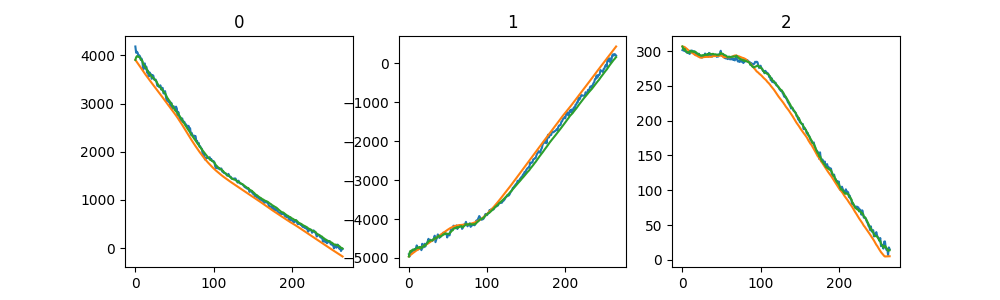

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    ax[i].plot(Yp[:, i], label="gt")
    ax[i].plot(Y[:, i], label="pred")
    ax[i].plot(Yf[:, i], label="filter")
    ax[i].set_ylim(min(0.0, ax[i].get_ylim()[0], min(1e3, max(0.0, ax[i].get_ylim()[1]))))
    ax[i].set_title(f"{i}")
plt.show()

# Verify data diversity

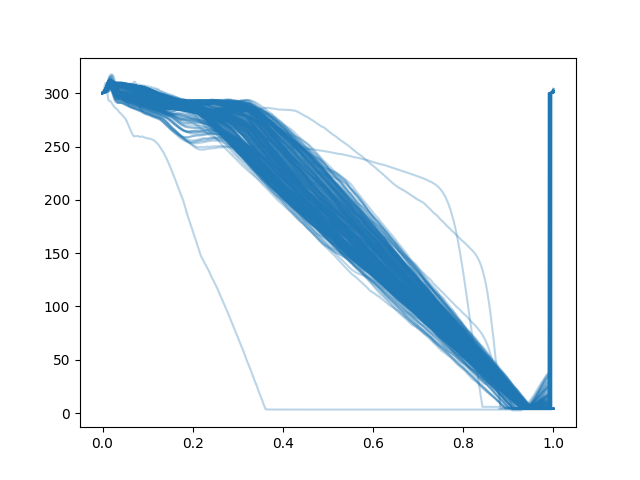

In [ ]:
plt.figure()
for i in range(len(ds.lengths)):
    data = np.array([x["state"] for x in json.loads(ds.data_files[i].read_text())])
    j = np.argmin(data[:, 2])
    plt.plot(np.linspace(0, 1, data.shape[0]), data[:, 2], alpha=0.3, color="C0")
    #print(data[j, :3])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


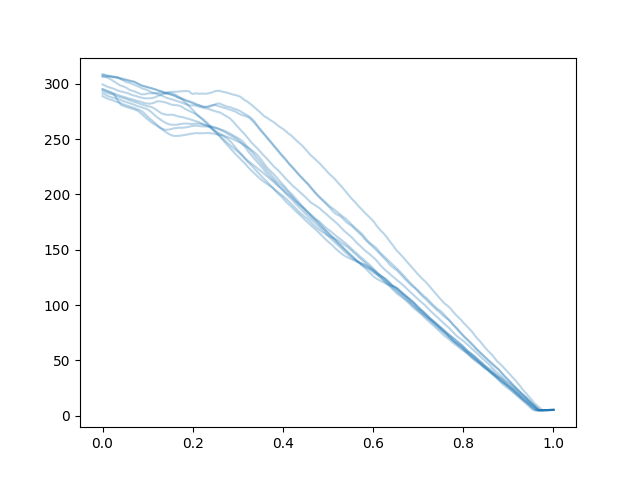

In [ ]:
plt.figure()
#for i in range(len(ds.lengths)):
for i in tqdm(range(min(10, len(ds.lengths)))):
    data = []
    for j in tqdm(range(ds.cumlengths[i], ds.cumlengths[i+1])):
        data.append(ds[j][1])
    data = np.array(data)
    plt.plot(np.linspace(0, 1, data.shape[0]), data[:, 2], alpha=0.3, color="C0")
plt.show()